In [1]:
import matplotlib.pyplot as plt
import torch
from botorch.models import ModelListGP
from botorch.optim import optimize_acqf
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
import numpy as np
from alse.eci import ExpectedCoverageImprovement
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints
from alse.fit_model import fit_gp_class, fit_gp_reg
from alse.test_function.fxns import yf, hills, circle
from alse.fit_all_demo_only import fit_all_models
from alse.plot_demo import plot_3_graphs, side_by_side, make_meshgrid
# from mpl_toolkits import mplot3d
# from matplotlib import cm

In [2]:
torch.cuda.is_available()

True

If no GPU change "cuda" to "cpu"

In [3]:
tkwargs = {
    # "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "device": torch.device("cpu"),
    "dtype": torch.double,
}

In [4]:
bounds = torch.tensor([[-3, -3], [3, 3]], **tkwargs)
lb, ub = bounds
dim = len(lb)
punchout_radius = 0.6

tensor([[ 1.1093, -2.3941],
        [-0.9986,  1.5060],
        [-2.0954, -0.6246],
        [ 2.1717,  1.4241],
        [ 2.7223, -1.0376]], dtype=torch.float64)


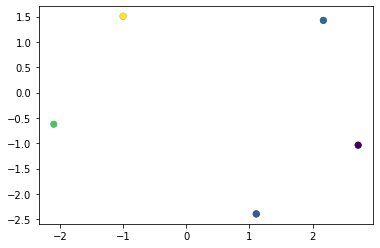

In [5]:
num_init_points = 5

X = lb + (ub - lb) * SobolEngine(dim, scramble=True).draw(num_init_points).to(**tkwargs)
Yhills = hills(X)
Ycircle = circle(X)
Yyf = yf(X)
plt.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c=Yhills.cpu()[:,0])
plt.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c=Ycircle.cpu()[:,0])
print(X)

In [6]:
gp_model_hills = fit_gp_reg(X, Yhills)
gp_model_circle = fit_gp_reg(X, Ycircle)
gp_model_class = fit_gp_class(X, Yyf, iter=300, lr=0.05)
model_list_gp = ModelListGP(gp_model_hills, gp_model_circle, gp_model_class)

c:\Program Files\Python310\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [7]:
def eval_mode():
    gp_model_hills.eval()
    gp_model_circle.eval()
    gp_model_class.eval()
    pass

In [8]:
constraints = [("gt", 0.3), ("gt", 20), ("gt", 0.1)]
# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std

# We don't have to normalize X since the domain is [0, 1]^2. Make sure to
# appropriately adjust the punchout radius if the domain is normalized.
def one_iter_eci(X, Yhills, Ycircle, Yyf):
    gp_model_hills = fit_gp_reg(X, Yhills)
    gp_model_circle = fit_gp_reg(X, Ycircle)
    gp_model_class = fit_gp_class(X, Yyf, iter=300, lr=0.05)
    model_list_gp = ModelListGP(gp_model_hills, gp_model_circle, gp_model_class)

    eci = ExpectedCoverageImprovement(
        model=model_list_gp,
        constraints=constraints,
        punchout_radius=punchout_radius,
        bounds=bounds,
        num_samples=512,
    )
    gp_model_hills.eval()
    gp_model_circle.eval()
    gp_model_class.eval()

    x_next, _ = optimize_acqf(
        acq_function=eci,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )

    return torch.cat((X, x_next))
# Yhills = torch.cat((Yhills, hills(x_next)))
# Ycircle = torch.cat((Ycircle, circle(x_next)))
# Yyf = torch.cat((Yyf, yf(x_next)))


In [9]:
X = one_iter_eci(X, Yhills, Ycircle, Yyf)

Yhills_temp = Yhills
Ycircle_temp = Ycircle
Yyf_temp = Yyf

c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


In [10]:
num_pred = 5

In [11]:
for i in range(num_pred-1):
    eval_mode()
                                                    #Last elem is x_next
    Yhills_temp = torch.cat((Yhills_temp, gp_model_hills(X[-1].unsqueeze(0)).loc.unsqueeze(-1)))
    Ycircle_temp = torch.cat((Ycircle_temp, gp_model_circle(X[-1].unsqueeze(0)).loc.unsqueeze(-1)))
    Yyf_temp = torch.cat((Yyf_temp, gp_model_class(X[-1].unsqueeze(0).float()).loc[0].unsqueeze(-1))) # Class 0

    # Fit models using the new X and predicted Y
                                    # Need to detach for some reason
    X = one_iter_eci(X, Yhills_temp.detach(), Ycircle_temp.detach(), Yyf_temp)

c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


In [12]:
X[-num_pred:]

tensor([[-1.5273,  0.4215],
        [-2.9419,  0.2112],
        [-1.8336,  2.2868],
        [-2.1546, -1.7249],
        [ 0.1675,  1.4275]], dtype=torch.float64)

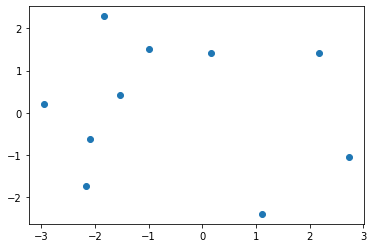

In [13]:
plt.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1])

In [14]:
for next_x in X[-num_pred:]:
    next_x = next_x.unsqueeze(0)
    Yhills = torch.cat((Yhills, hills(next_x)))
    Ycircle = torch.cat((Ycircle, circle(next_x)))
    Yyf = torch.cat((Yyf, yf(next_x)))